In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import gc

from astropy.visualization import astropy_mpl_style
from astropy.io import fits

from skimage.transform import resize
from skimage.filters import threshold_otsu

plt.style.use(astropy_mpl_style)

# =====================================================================================================
# Подынтегральные функции для монохроматического случая
def gamma_mono_int(fx, fy, z, lambda_, delta): 
    def aperture_func(fx, fy, delta): # A(-f)
        res = np.abs(np.sinc(delta*(-fx))*np.sinc(delta*(-fy)))**2
        return res
    
    def abs_f(fx, fy): # |f|^(-11/3)
        res = pow(np.sqrt(fx**2+fy**2), -11./3.)
        return res

    def sin(fx, fy, z, lambda_): # sin^2(pi*z*lambda*|f|^2)/lambda^2
        res = pow(np.sin(np.pi*z*lambda_*(fx**2+fy**2)), 2) / pow(lambda_, 2)
        return res

    def abs_f_with_sin(fx, fy, z, lambda_):
        res = abs_f(fx, fy) * sin(fx, fy, z, lambda_)
        res[np.isnan(res)] = 0
        return res
    
    res = abs_f_with_sin(fx, fy, z, lambda_) * aperture_func(fx, fy, delta)
    return np.fft.fftshift(np.real(np.fft.ifft2(np.fft.fftshift(res))))

# =====================================================================================================
# c_jk
def c(data, nx): 
    img = data[0]
    data_pupil = np.pad(img, ((228 - img.shape[0], 0), (0, 228 - img.shape[1])), 'constant', constant_values=(0))
    I0c = (data_pupil != 0) * int(1)
    I0c = np.pad(I0c, ((nx - I0c.shape[0])//2, (nx - I0c.shape[1])//2), 'constant', constant_values=(0))
    c_jk = np.fft.fftshift(np.real(np.fft.ifft2(np.fft.fft2(I0c)*np.fft.fft2(I0c).conjugate())))
    c_jk /= np.max(c_jk)
    return c_jk
       

# =====================================================================================================
# Корреляция
def correlate(data, latency): 
    correlation = np.zeros_like(data)
    def correlate_fft(img1, img2):
        corr = np.fft.fftshift(np.real(np.fft.ifft2(np.fft.fft2(img1)*np.fft.fft2(img2).conjugate()))) # np.real; np.abs
        corr /= np.max(corr)
        return corr
    
    for i in range(data.shape[0] - latency):
        correlation[i] = correlate_fft(data[i], data[i + latency])
    
    return np.mean(correlation, axis=0)
    
# =====================================================================================================
# Получение обрезанного изображения зрачка
def pupil(data):  
    def avr_data(data):
        return np.mean(data, axis=0)
    
    def norm_data(data):
        return (data)/(avr_data(data)) - 1

    def otsu_tresh(image_gray):
        return threshold_otsu(image_gray)
    
    def im_bin(data):
        return (avr_data(data) > otsu_tresh(avr_data(data))) * int(255)

    def otsu_res(data):
        return norm_data(data) * im_bin(data)

    def sq_cropp(data):
        mask = otsu_res(data)[0] != 0
        rows = np.flatnonzero((mask.any(axis=1))) 
        cols = np.flatnonzero((mask.any(axis=0)))
        squared = otsu_res(data)[:, rows.min():rows.max()+1, cols.min():cols.max()+1] 
        return squared 
    
    return sq_cropp(data)   

# =====================================================================================================
# Отрисовка скорости ветра и турбулентных пятен
def draw_correlate_with_velocity(data, D, latency, frames_per_sec): 
    def v(D, img, latency, frames_per_sec):
        return (D / img.shape[1]) / (latency * frames_per_sec)
    
    def cross_corr_with_velocity(data, D, latency, frames_per_sec): 
        img = data.copy()
        x = np.round(v(D, img, latency, frames_per_sec)*np.linspace(-img.shape[0]//2, img.shape[0]//2, 5), 2)
        fig = plt.figure()
        ax = plt.axes()
        im = plt.imshow(img)
        ax.set_xticks(np.linspace(0, img.shape[1], 5))
        ax.set_yticks(np.linspace(0, img.shape[0], 5))
        ax.set_xticklabels(x, fontsize=12)
        ax.set_yticklabels(x, fontsize=12)
        ax.set_ylabel('Vy, m/s', fontsize=12)
        ax.set_xlabel('Vx, m/s', fontsize=12)
        cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
        plt.colorbar(im, cax=cax)
        ax.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.4)

Filename: C:\Users\miron\coding\DomecamDraft\bias20210130.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      15   (329, 246, 1000)   int16 (rescales to uint16)   
Filename: C:\Users\miron\coding\DomecamDraft\20210130l_m2km.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      15   (329, 246, 6000)   int16 (rescales to uint16)   
 
time: 165.000987


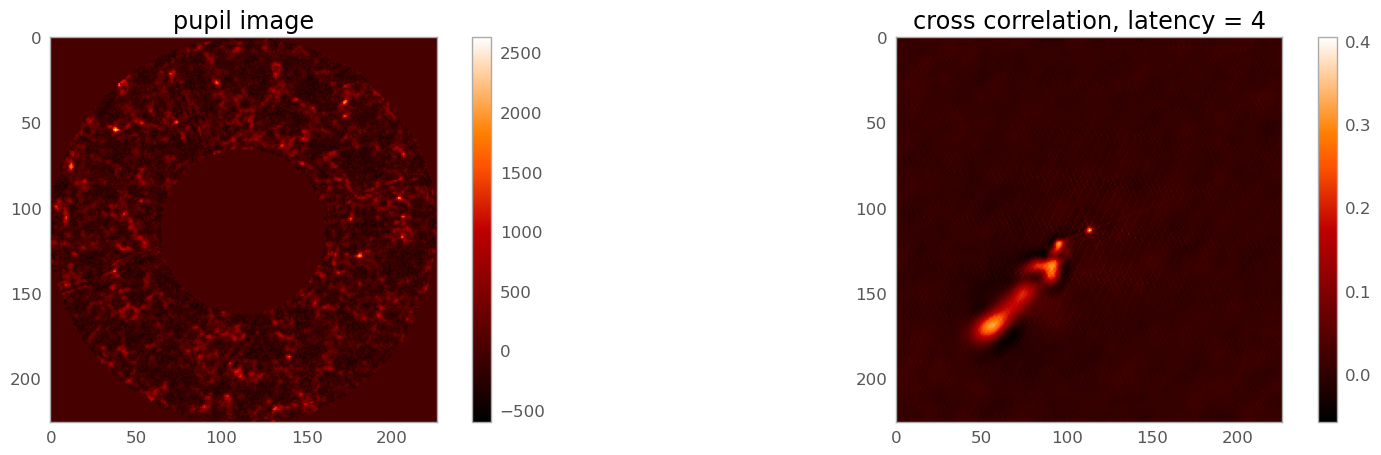

In [2]:
file = '20210130l_m2km.fits'
file_bias = 'bias20210130.fits'

latency = 4 # задержка в кросс-корреляции

st = time.perf_counter()
with fits.open(os.path.abspath(file_bias)) as fb:
    fb.info()
    bias = np.mean(fb[0].data.astype(np.float32), axis=0)
    
with fits.open(os.path.abspath(file)) as f:
    f.info()
    frames_per_sec = 1 / f[0].header['FRATE']
    data = pupil(f[0].data.astype(np.float32) - bias)
#     data = resize(df, (df.shape[0], df.shape[1] // 3, df.shape[2] // 3), anti_aliasing=False)
    data_corr = correlate(data, latency)
    

fig, (ax_img, ax_img2) = plt.subplots(1, 2, figsize=(20, 5))

ax_img.imshow(data[0])
fig.colorbar(ax_img.imshow(data[0]), ax = ax_img)
ax_img.set_title('pupil image')
ax_img.grid(False)

ax_img2.imshow(data_corr)
fig.colorbar(ax_img2.imshow(data_corr), ax = ax_img2)
ax_img2.set_title(f'cross correlation, latency = {latency}')
ax_img2.grid(False)

print(' ')
print('time:', time.perf_counter()-st)

In [3]:
'''
Ex:

Для примера пусть Cn2 соответствует качеству изображения, равному 1 угловой секунде (типичное качество изображения) на длине 
волны 500 нм. Для удобства величину Cn2(z)dz рассматриваем как одну величину, обозначим ее C. Тогда:
    beta = 0.98 * lambda/r0 = 1, следовательно: r0 = 0.98*lambda*206265,
Пусть мы наблюдаем в зените, тогда параметр Фрида будет:
    r0 = (0.423*k^2 * C)^(-3/5), где k = 2*pi/lambda.
Далее можно просто выразить и посчитать С
'''
D = 2.5 # диаметр телескопа, [м]
lambda_ = 500*pow(10, -9) # длина волны, [м]
z = 2000 # дистанция распространения, [м]
Cn2_ex = pow((0.98*lambda_)*206265, -5/3) / (0.423*pow(2*np.pi/lambda_, 2))

const = 9.69*pow(10, -3)*16*pow(np.pi, 2) # Константа перед интегралом 
D_pix = 228 # диаметр телескопа в пикселях
nx = 512 # кол-во пикселей. для отображения полного результата c_jk кол-во пикселей должно быть как минимум в два раза больше, 
# чем на исходном изображении-зрачке
f_scale = D_pix/(D*nx) # шаг по частоте, [м^-1]
delta = D/D_pix # шаг апертуры (соотношение между 1 пикселем и метрами, т.е. 1 пикс = 0.01 м) 

xx, yy = np.meshgrid(np.linspace(-nx//2, nx//2-1, nx), np.linspace(-nx//2, nx//2-1, nx))
xx_scale = f_scale * xx 
yy_scale = f_scale * yy
                                                                           
gamma = Cn2_ex * const * c(data, nx) * gamma_mono_int(xx_scale, yy_scale, z, lambda_, delta) * pow(f_scale, 2) * nx * nx # подсчет гаммы 
k = np.max(data_corr[104:124, 104:124]) / np.max(gamma) # коэфф домножения = отношение реальной гаммы и искуственной в центре изображения
Cn2 = Cn2_ex * k # реальное значение Cn2 на дистанции распространения z

gamma_new = Cn2 * const * c(data, nx) * gamma_mono_int(xx_scale, yy_scale, z, lambda_, delta) * pow(f_scale, 2) * nx * nx

print('NaNs:', np.count_nonzero(np.isnan(gamma)))
print('gamma shape:', gamma.shape)
print('max gamma value:', np.unravel_index(np.argmax(gamma), gamma.shape), '=', np.max(gamma))
print('max data_corr value =', np.unravel_index(np.argmax(data_corr), data_corr.shape), '=', np.max(data_corr))
print('k = max data_corr value / max gamma value =', k)
print('if seeing = 1, then Cn2_ex =', Cn2_ex)
print('Cn2 = Cn2_ex * k =', Cn2)

NaNs: 0
gamma shape: (512, 512)
max gamma value: (256, 256) = 0.13247313498922997
max data_corr value = (113, 113) = 0.40507408099072595
k = max data_corr value / max gamma value = 3.057782855547718
if seeing = 1, then Cn2_ex = 6.826590771729513e-13
Cn2 = Cn2_ex * k = 2.0874232223634768e-12


C:\Users\miron\AppData\Local\Temp\ipykernel_13048\2288228017.py:23: RuntimeWarning: divide by zero encountered in power
  res = pow(np.sqrt(fx**2+fy**2), -11./3.)
C:\Users\miron\AppData\Local\Temp\ipykernel_13048\2288228017.py:31: RuntimeWarning: invalid value encountered in multiply
  res = abs_f(fx, fy) * sin(fx, fy, z, lambda_)


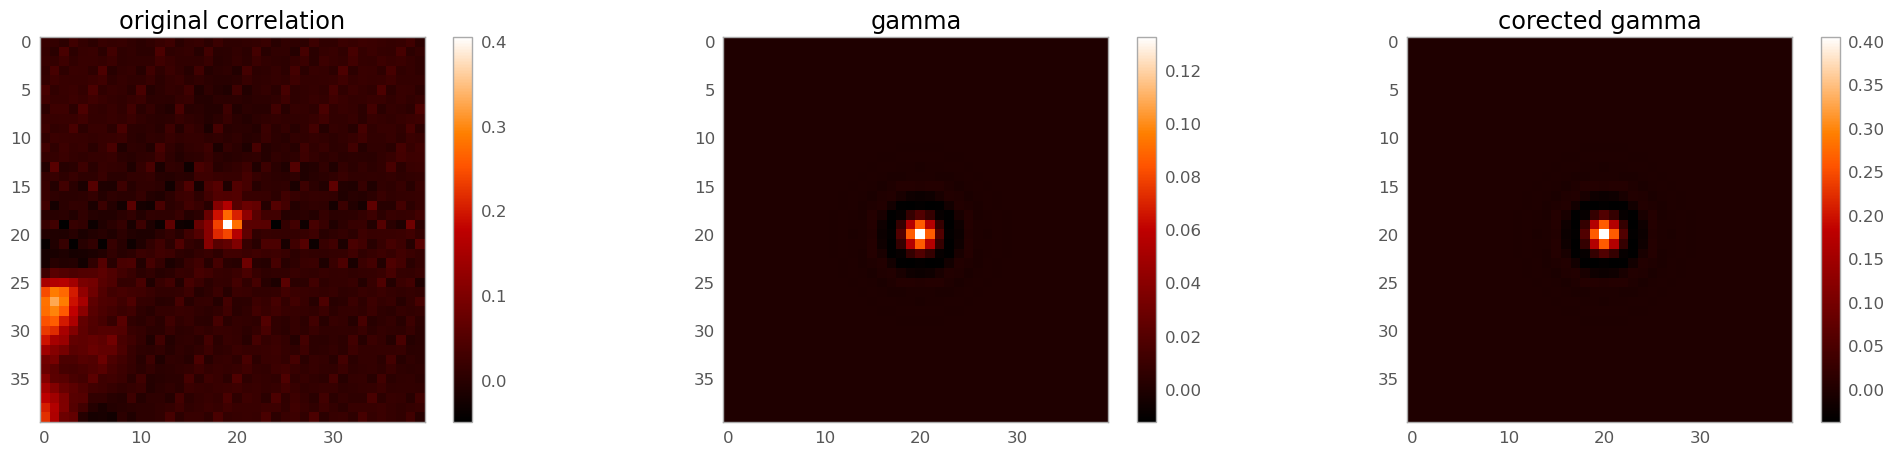

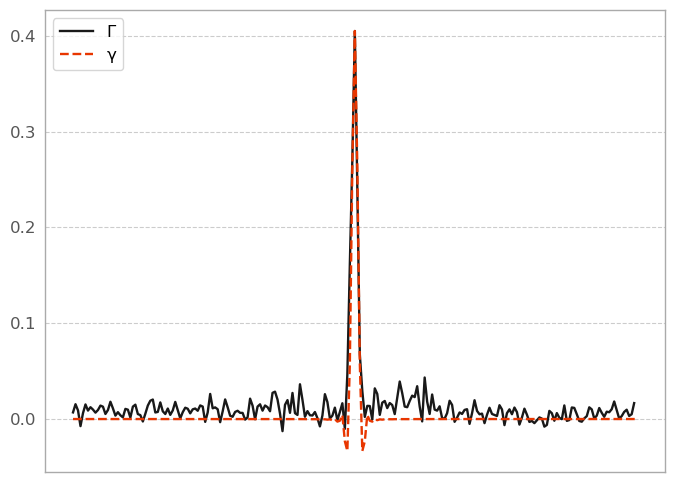

In [4]:
Y = data_corr[:, 113]
X = range(226)
Y2 = gamma[143:370, 256]
X2 = range(227)
Y3 = gamma_new[143:370, 256]
X3 = range(227)

fig, (ax_img, ax_img3, ax_img4) = plt.subplots(1, 3, figsize=(25, 5))

fig.colorbar(ax_img.imshow(data_corr[94:134, 94:134]), ax = ax_img)
ax_img.set_title('original correlation')
ax_img.grid(False)

fig.colorbar(ax_img3.imshow(gamma[236:276, 236:276]), ax = ax_img3)
ax_img3.set_title('gamma')
ax_img3.grid(False)

fig.colorbar(ax_img4.imshow(gamma_new[236:276, 236:276]), ax = ax_img4)
ax_img4.set_title('corected gamma')
ax_img4.grid(False)


plt.figure()
plt.plot(X, Y, alpha = 0.9, label = 'original corr', color = '#000000')
plt.plot(X3, Y3, alpha = 1, ls = '--', label = 'corected gamma', color = '#e83600')
plt.legend(['Γ', 'γ'], loc=2, prop={'size': 12})
plt.xticks([])
plt.grid(color = 'black', linestyle='--', alpha = 0.2)
plt.savefig('C:/astro/teor_corr.png', bbox_inches='tight')

In [5]:
# def gamma_poly_int(fx, fy, z, lambda_, delta): # Подынтегральные функции для полихроматического случая
#     def aperture_func(fx, fy, delta): # A(-f)
#         res = np.abs(np.sinc(delta*(-fx))*np.sinc(delta*(-fy)))**2
#         return res
    
#     def a1(fx, fy): # |f|^(-11/3)
#         res = pow(np.sqrt(fx**2+fy**2), -11./3.)
#         return res

#     def S(fx, fy, z, lambda_): # sin^2(pi*z*lambda*|f|^2)/lambda^2
#         res = pow(np.sin(np.pi*z*lambda_*(fx**2+fy**2)), 2) / pow(lambda_, 2)
#         return res
    
#     return a1(fx, fy) * aperture_func(fx, fy, delta) * S

In [6]:
'''
data_test = data
print('data test shape:', data_test.shape)
st = time.perf_counter()

data_resized = resize(data_test, (data_test.shape[0], data_test.shape[1] // 3, data_test.shape[2] // 3), anti_aliasing=False)
data_avr_corr = cross_corr(data_resized, 4) 

kern = np.array([[ -1, -2, -1],
                 [ -2, 22, -2],
                 [ -1, -2, -1]])
data_box_filter = cvf.box_filter(data_avr_corr, kern)
data_resized_back = resize(data_box_filter, (data_test.shape[1], data_test.shape[2]), anti_aliasing=False)
# data_resized_back = resize(data_avr_corr, (data_test.shape[1], data_test.shape[2]), anti_aliasing=False)



print('time:', time.perf_counter() - st)

print('data resized back shape:', data_resized_back.shape)
draw_corr_with_velocity(data_resized_back, 2.5, 4, frames_per_sec)

data_uint = img_as_ubyte(data_resized_back)
print('otsu tresh:', otsu_tresh(data_uint))
data_otsu = (data_uint > otsu_tresh(data_uint)) * int(255)
fig = plt.figure()
ax = plt.axes()
im = plt.imshow(data_otsu)

# window = np.ones((7, 7))
# data_median = cvf.median_filter(data_otsu, window)
# fig = plt.figure()
# ax = plt.axes()
# im = plt.imshow(data_median)

del data_test
'''

"\ndata_test = data\nprint('data test shape:', data_test.shape)\nst = time.perf_counter()\n\ndata_resized = resize(data_test, (data_test.shape[0], data_test.shape[1] // 3, data_test.shape[2] // 3), anti_aliasing=False)\ndata_avr_corr = cross_corr(data_resized, 4) \n\nkern = np.array([[ -1, -2, -1],\n                 [ -2, 22, -2],\n                 [ -1, -2, -1]])\ndata_box_filter = cvf.box_filter(data_avr_corr, kern)\ndata_resized_back = resize(data_box_filter, (data_test.shape[1], data_test.shape[2]), anti_aliasing=False)\n# data_resized_back = resize(data_avr_corr, (data_test.shape[1], data_test.shape[2]), anti_aliasing=False)\n\n\n\nprint('time:', time.perf_counter() - st)\n\nprint('data resized back shape:', data_resized_back.shape)\ndraw_corr_with_velocity(data_resized_back, 2.5, 4, frames_per_sec)\n\ndata_uint = img_as_ubyte(data_resized_back)\nprint('otsu tresh:', otsu_tresh(data_uint))\ndata_otsu = (data_uint > otsu_tresh(data_uint)) * int(255)\nfig = plt.figure()\nax = plt.ax